# Initial Setup

In [1]:
from datetime import datetime as dt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from utils import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
#set up matplotlib
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (30, 15),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# constants
MOVING_AVERAGE_WINDOW_SIZE = 10
PREDICTION_WINDOW_SIZE = 50
EPOCH = 100
BATCH_SIZE = 30
LSTM_UNITS = 60
DROPOUT = 0.2
NUM_LSTM_LAYERS = 4

# Utility Functions

In [3]:
def show_graph(data):
    plt.plot(data['Open'])
    plt.xlabel('Date')
    plt.ylabel('Open')
    plt.title('Trend of DJIA Open')
    plt.show()

def get_moving_window_dataframes(data, window_size):
    averages, trends = pd.DataFrame(), pd.DataFrame()
    for column in list(data):
        averages[column] = get_moving_averages(data[column], window_size)
        trends[column] = get_trend(averages[column]) if column != 'Open' else averages[column][1:]
    return averages, trends

def split_to_prediction_windows(data, prediction_window, use_all_predictors):
    x = []
    y = []
    for i in range(prediction_window, len(data)):
        x.append(data[i - prediction_window: i, :] if use_all_predictors else data[i - prediction_window: i, 0])
        y.append(data[i, 0])
    x = np.array(x)
    x = x.reshape(x.shape[0], x.shape[1], 6 if use_all_predictors else 1)
    return x, np.array(y)

def generate_train_test_prediction_windows(train, test, prediction_window_size, use_all_predictors):
    x_train, y_train = split_to_prediction_windows(train, prediction_window_size, use_all_predictors)
    x_test, y_test = split_to_prediction_windows(test, prediction_window_size, use_all_predictors)
    return x_train, y_train, x_test, y_test

def train_model(x_train, y_train, units, dropout, num_lstm_layers):
    model = Sequential(
        [
            LSTM(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
            Dropout(dropout)
        ] +
        [
            LSTM(units, return_sequences=True),
            Dropout(dropout)
        ] * (num_lstm_layers - 2) +
        [
            LSTM(units),
            Dropout(dropout),
            Dense(1)
        ])
    model.compile(optimizer='rmsprop',loss='mean_squared_error')
    history = model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE)
    return model, history
    
def plot_prediction(scaler, x_test, y_test, model):
    y_predict = model.predict(x_test)
    plt.plot(inverse_transform_single_column(scaler, y_test, 6), color='blue',label='Real DJIA')
    plt.plot(inverse_transform_single_column(scaler, y_predict, 6), color='red',label='Predicted DJIA')
    plt.title('DJIA Prediction')
    plt.xlabel('Time')
    plt.ylabel('DJIA')
    plt.legend()
    plt.show()

# Data Cleaning

In [4]:
djia = pd.read_csv('djia.csv', index_col='Date', parse_dates=['Date'], date_parser=lambda date: dt.strptime(date,'%d/%m/%Y').date())

In [5]:
djia.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


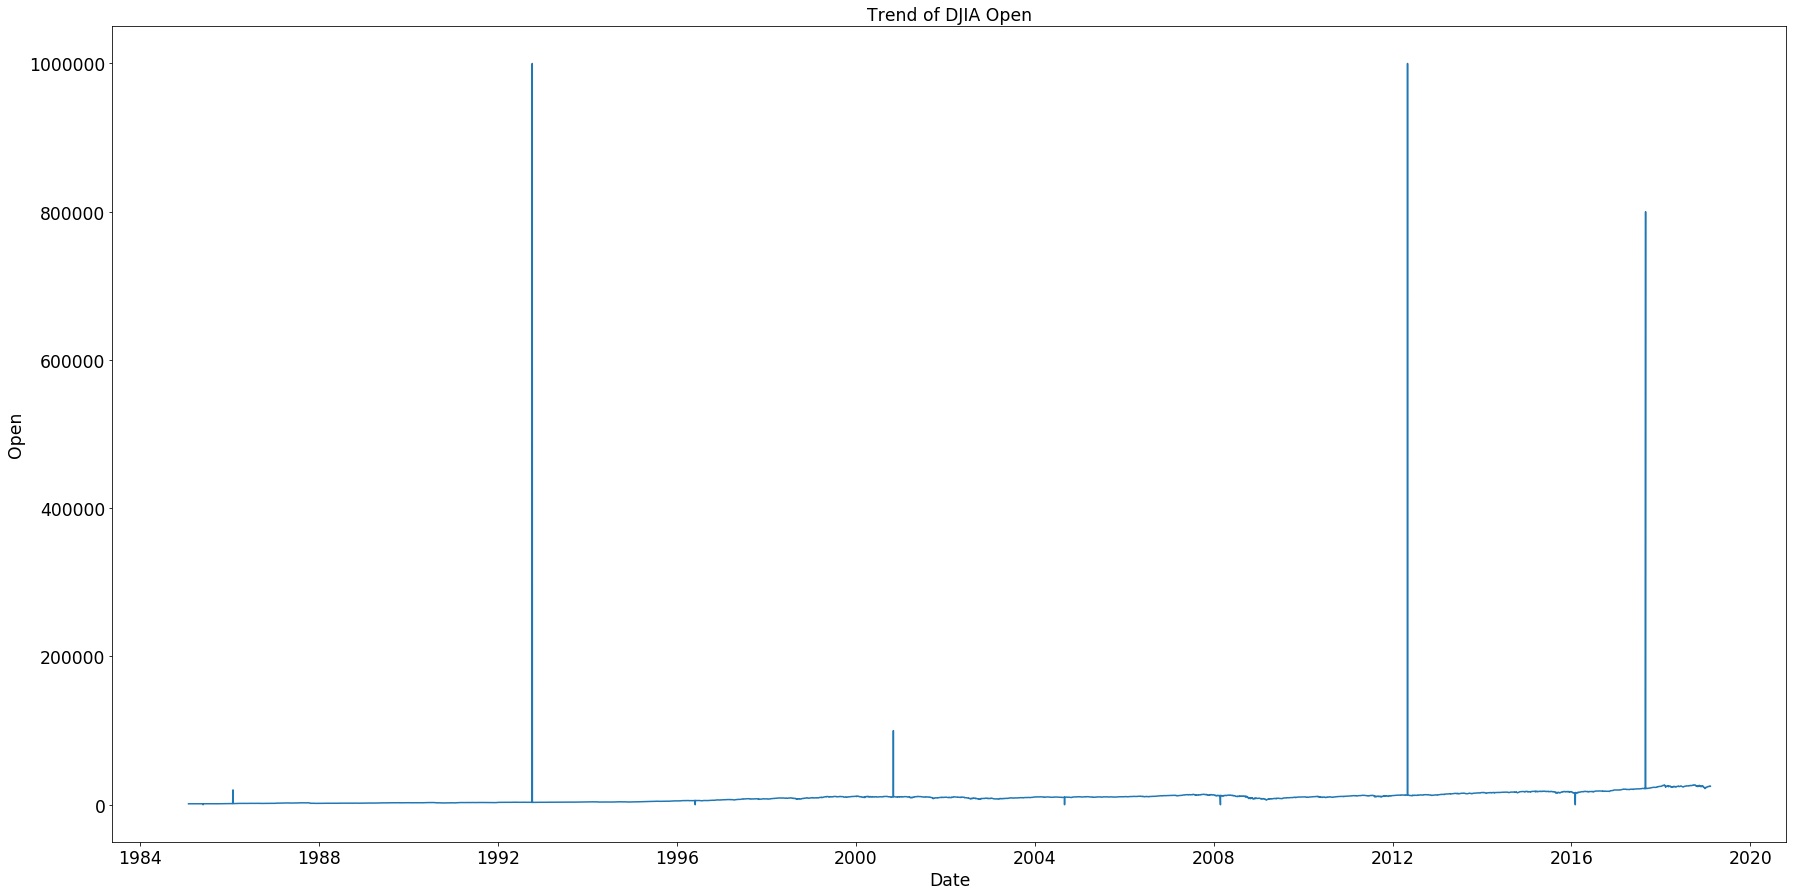

In [6]:
show_graph(djia)

In [7]:
# remove outliers and bad data
djia = djia[(djia['Open'] < 60000) & (djia['Open'] > 0) & (djia['High'] > djia['Low'])]

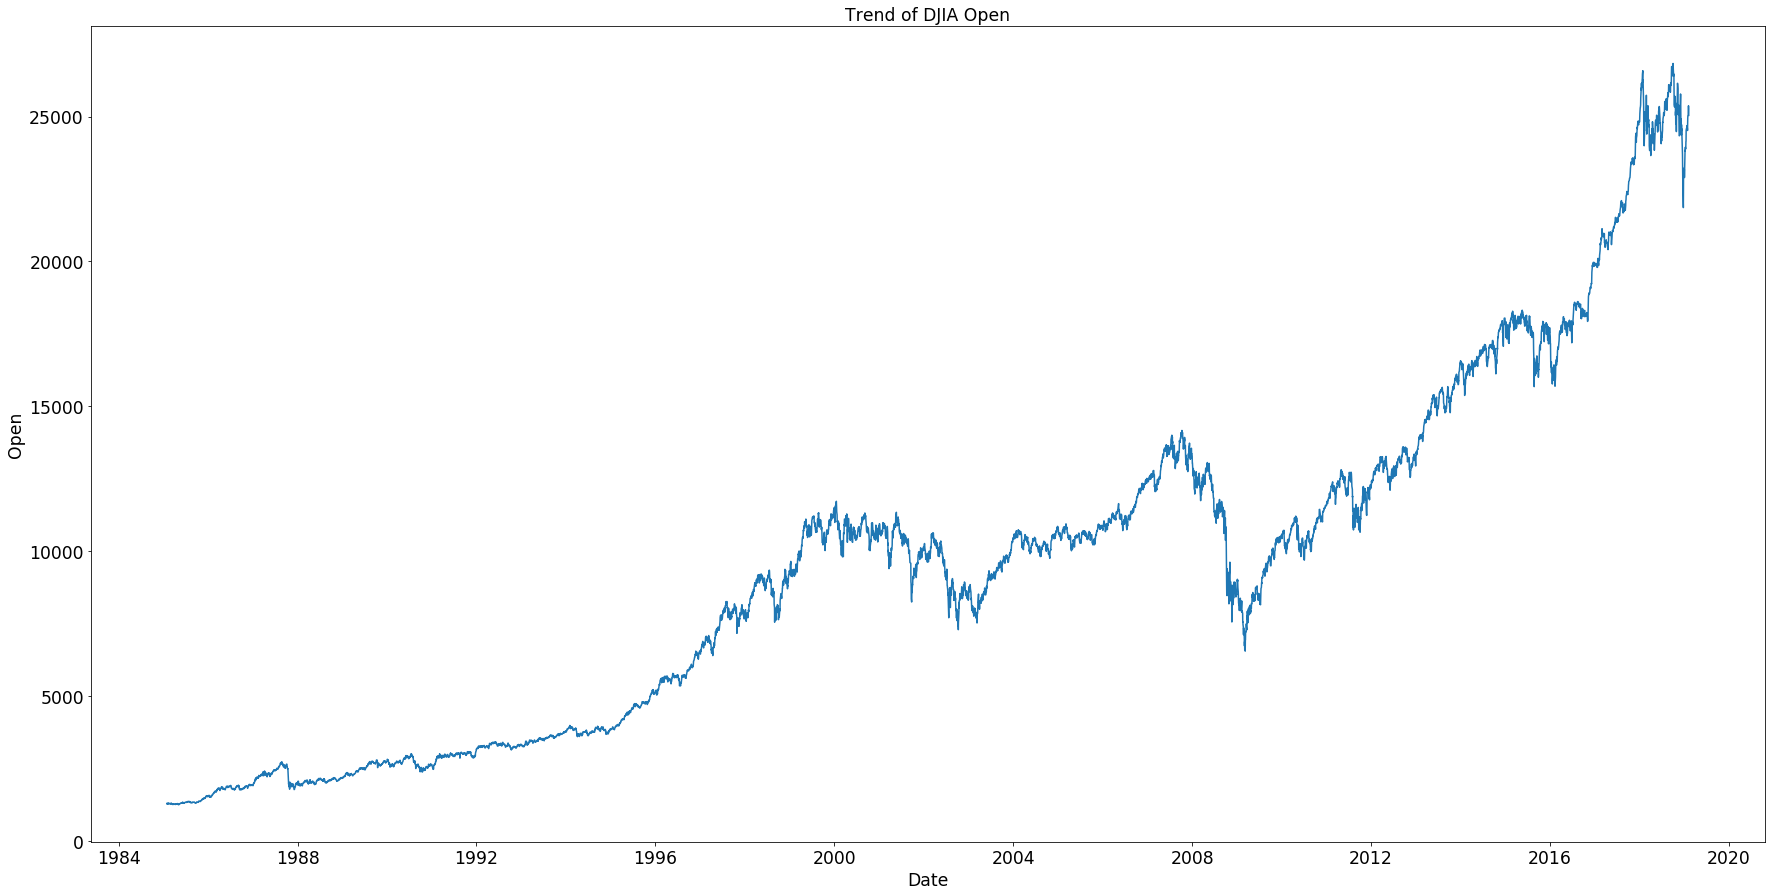

In [8]:
show_graph(djia)

In [9]:
averages, trends = get_moving_window_dataframes(djia, MOVING_AVERAGE_WINDOW_SIZE)

In [10]:
averages.head()

,Open,High,Low,Close,Adj Close,Volume
0,1284.936987,1295.659997,1274.072009,1285.699988,1285.699988,12751000
1,1284.284985,1294.423999,1274.017004,1284.098987,1284.098987,12582000
2,1282.330981,1294.380005,1273.575000,1285.102991,1285.102991,12305000
3,1284.185986,1295.793005,1274.679004,1285.213989,1285.213989,12300000
4,1285.411987,1296.809009,1275.208997,1285.643994,1285.643994,12075000


In [11]:
trends.head()

,Open,High,Low,Close,Adj Close,Volume
1,1284.284985,False,False,False,False,False
2,1282.330981,False,False,True,True,False
3,1284.185986,True,True,True,True,False
4,1285.411987,True,True,True,True,False
5,1286.184998,False,True,False,False,False


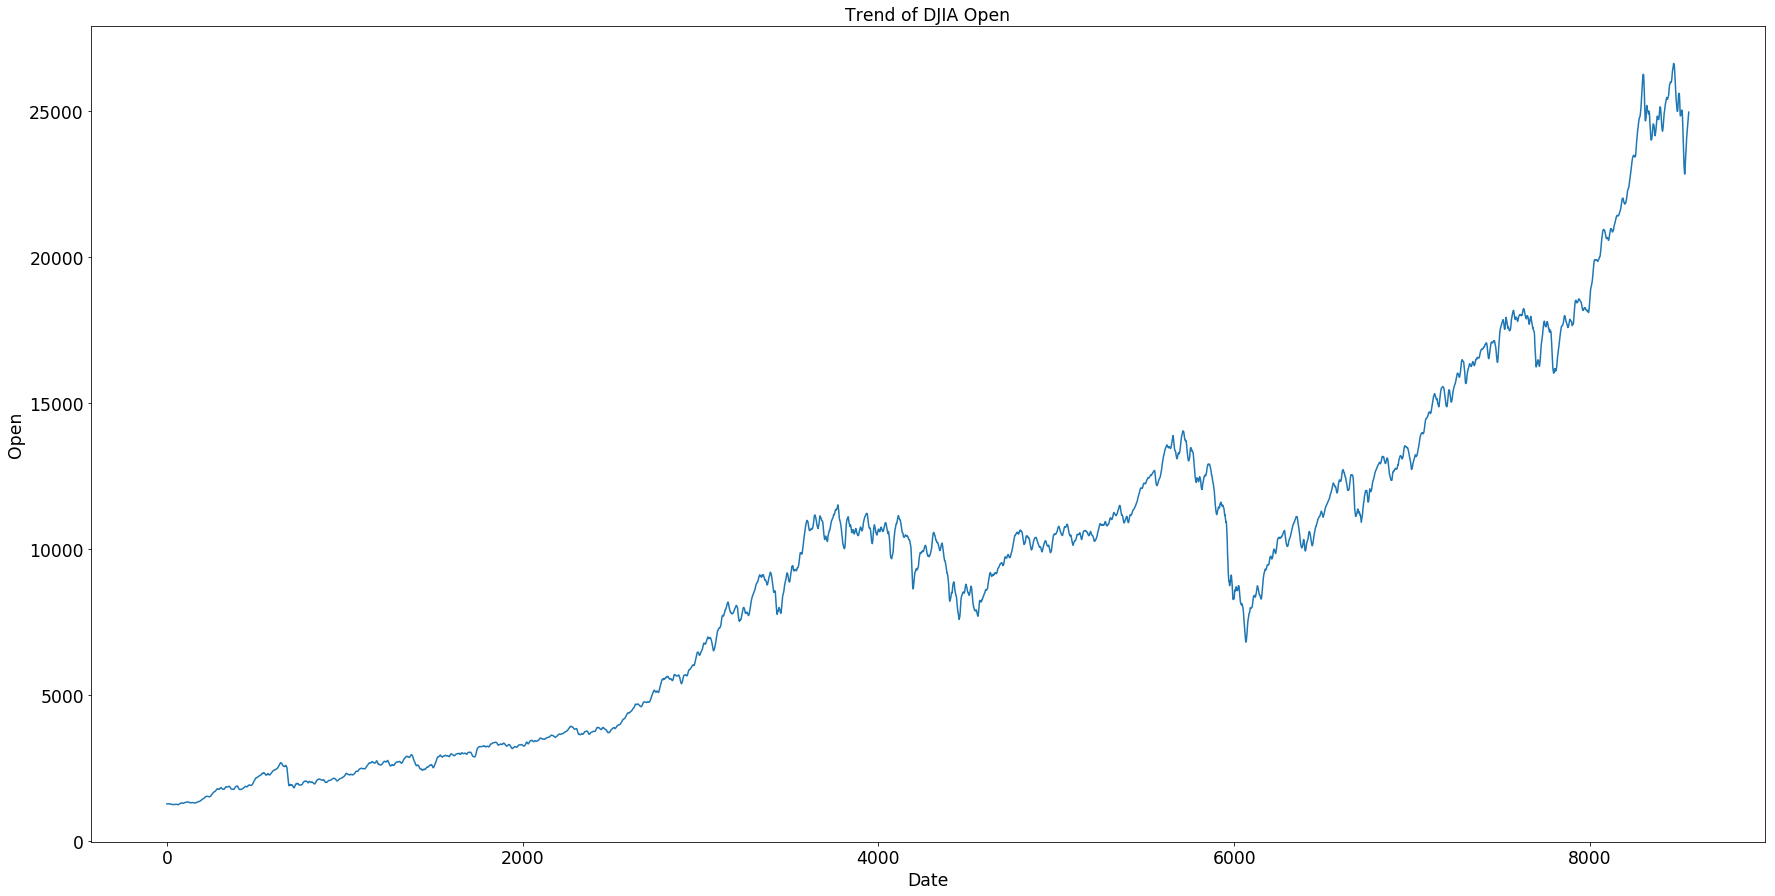

In [12]:
show_graph(averages)

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
djia_matrix = scaler.fit_transform(averages[-1000:])
djia_matrix_train = djia_matrix[:700]
djia_matrix_test = djia_matrix[700:]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Trend Predictors Model

In [14]:
trend_scaler = MinMaxScaler(feature_range=(0,1))
trends = trends[-1000:]
trends[['Open']] = trend_scaler.fit_transform(trends[['Open']])
djia_trends = trends.values
djia_trends_train = djia_trends[:700]
djia_trends_test = djia_trends[700:]

In [15]:
x_train, y_train, x_test, y_test = generate_train_test_prediction_windows(djia_trends_train, djia_trends_test, PREDICTION_WINDOW_SIZE, True)
model_trend_predictors, history_trend_predictors = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
650/650 [==============================] - 4s 6ms/step - loss: 0.0324
Epoch 2/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0131
Epoch 3/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0107
Epoch 4/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0049
Epoch 5/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0085
Epoch 6/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0052
Epoch 7/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0049
Epoch 8/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0040
Epoch 9/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0053
Epoch 10/100
650/650 [=====

650/650 [==============================] - 2s 3ms/step - loss: 9.4149e-04
Epoch 89/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0012
Epoch 90/100
650/650 [==============================] - 2s 3ms/step - loss: 9.9475e-04
Epoch 91/100
650/650 [==============================] - 2s 3ms/step - loss: 8.5137e-04
Epoch 92/100
650/650 [==============================] - 2s 3ms/step - loss: 9.7389e-04
Epoch 93/100
650/650 [==============================] - 2s 3ms/step - loss: 9.3271e-04
Epoch 94/100
650/650 [==============================] - 2s 3ms/step - loss: 9.0000e-04
Epoch 95/100
650/650 [==============================] - 2s 3ms/step - loss: 8.8007e-04
Epoch 96/100
650/650 [==============================] - 2s 3ms/step - loss: 9.2694e-04
Epoch 97/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0010
Epoch 98/100
650/650 [==============================] - 2s 3ms/step - loss: 8.3087e-04
Epoch 99/100
650/650 [==============================] - 2s 3ms/s

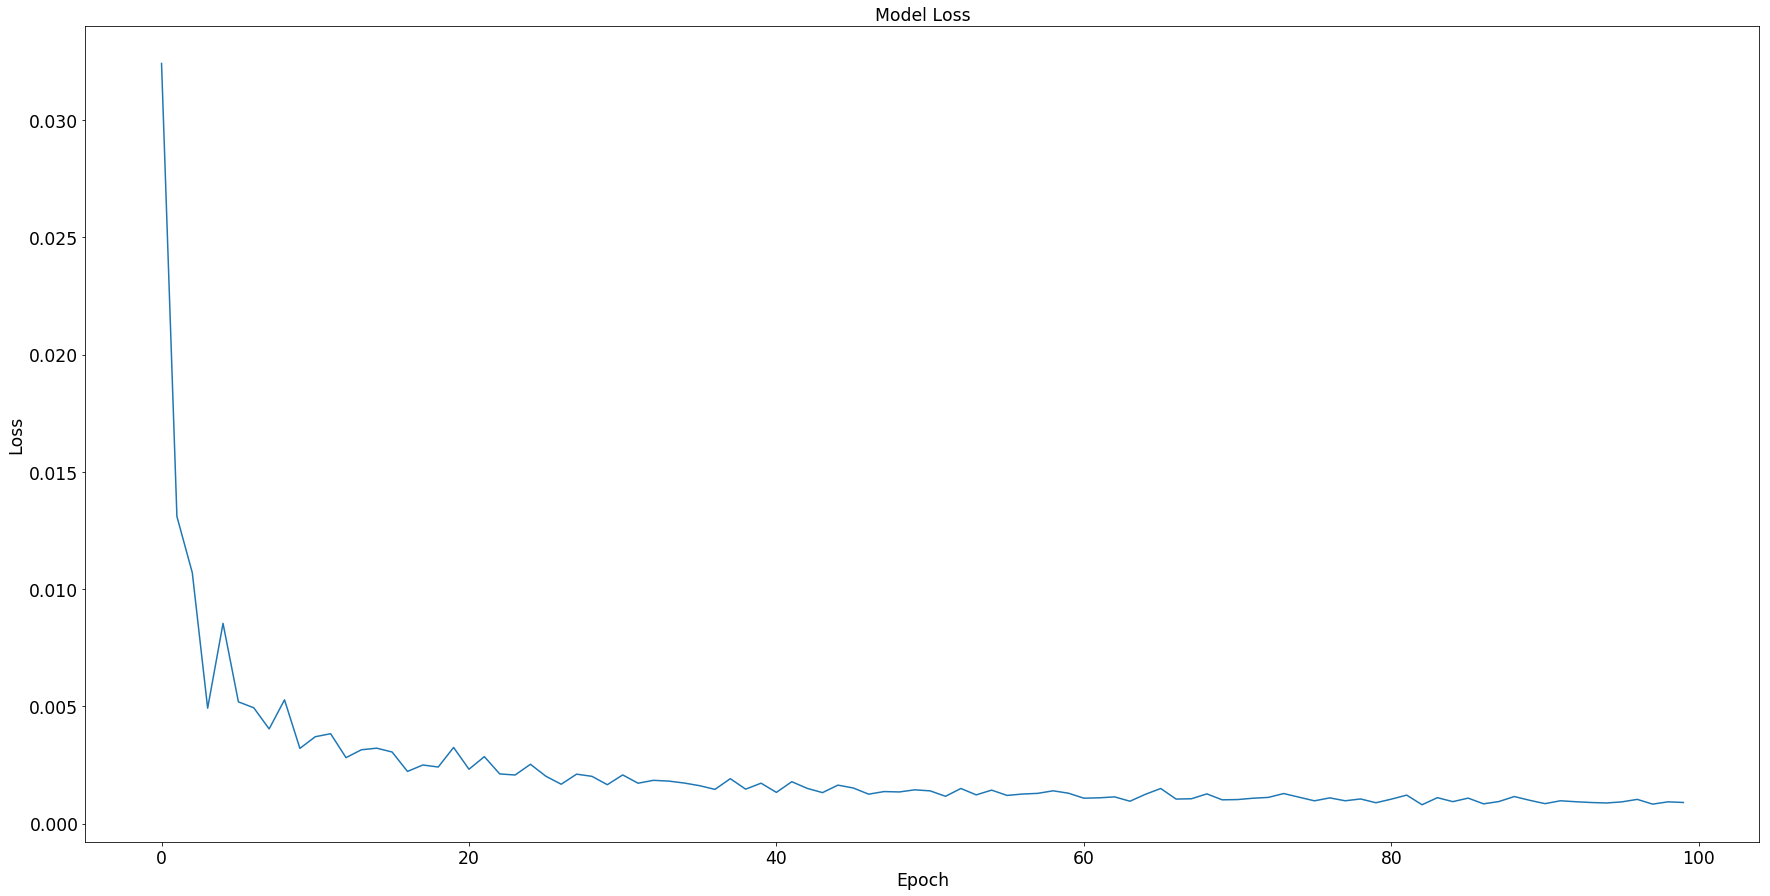

In [16]:
plot_loss(history_trend_predictors)

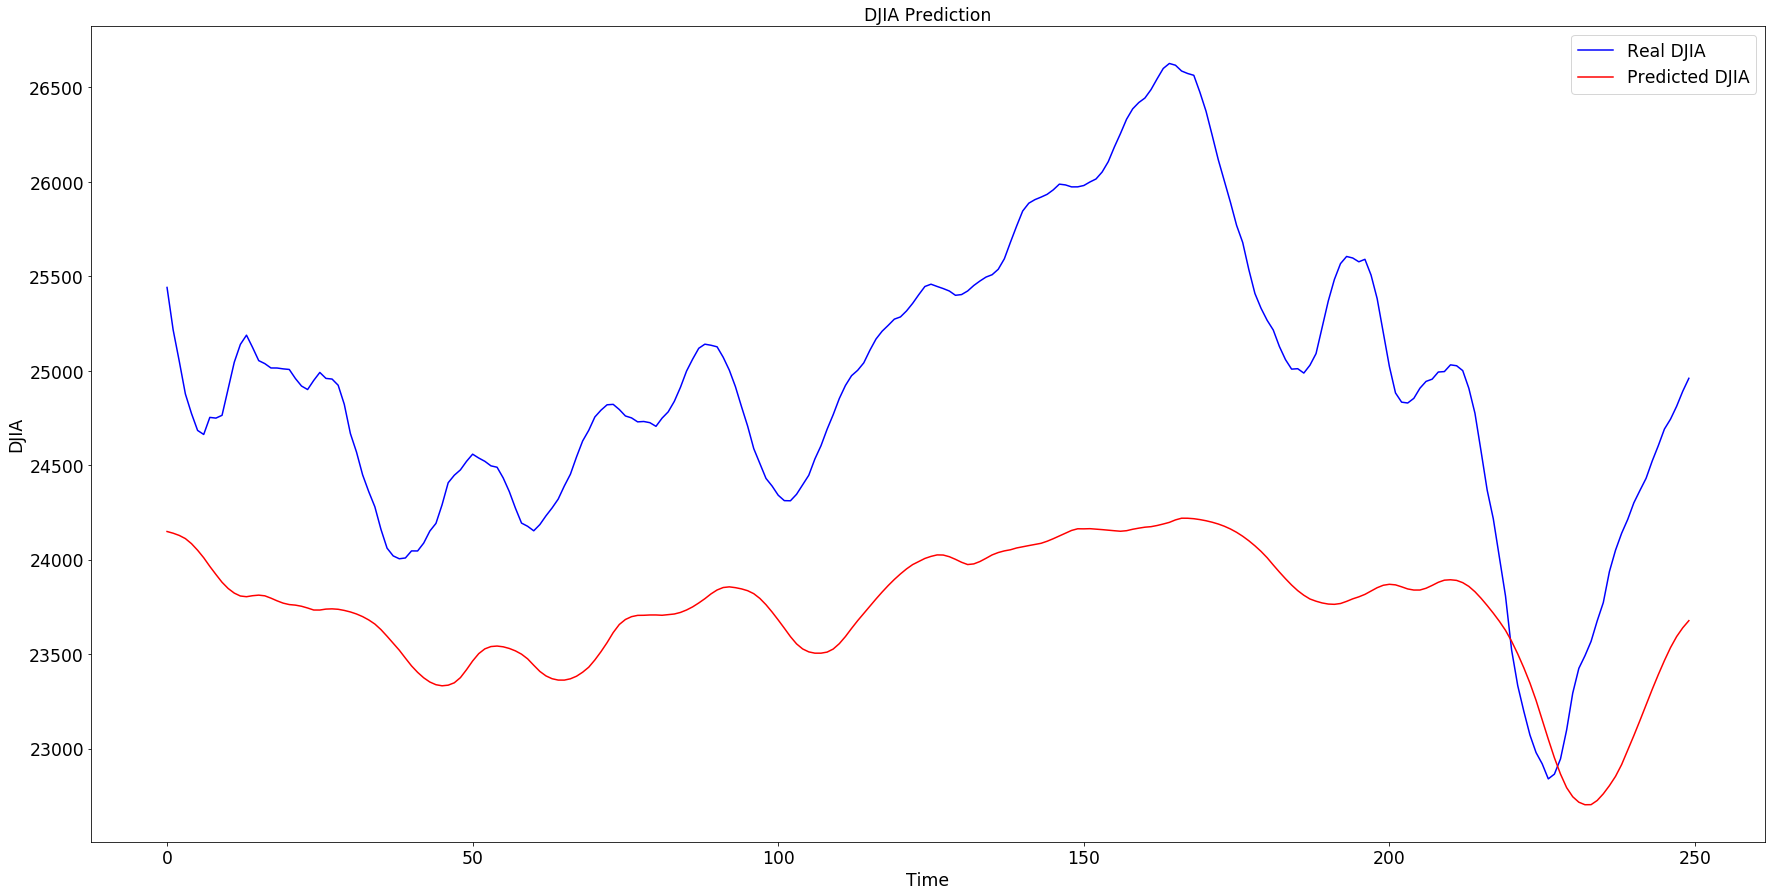

In [17]:
plot_prediction(trend_scaler, x_test, y_test, model_trend_predictors)

# All Predictors Model

In [18]:
x_train, y_train, x_test, y_test = generate_train_test_prediction_windows(djia_matrix_train, djia_matrix_test, PREDICTION_WINDOW_SIZE, True)
model_all_predictors, history_all_predictors = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS)

Epoch 1/100
650/650 [==============================] - 4s 6ms/step - loss: 0.0160
Epoch 2/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0059
Epoch 3/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0069
Epoch 4/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0044
Epoch 5/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0045
Epoch 6/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0048
Epoch 7/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0048
Epoch 8/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0031
Epoch 9/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0044
Epoch 10/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0030
Epoch 11/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0024
Epoch 12/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0037
Epoch 13/100


650/650 [==============================] - 2s 3ms/step - loss: 6.4927e-04
Epoch 98/100
650/650 [==============================] - 2s 3ms/step - loss: 6.5349e-04
Epoch 99/100
650/650 [==============================] - 2s 3ms/step - loss: 6.0009e-04
Epoch 100/100
650/650 [==============================] - 2s 3ms/step - loss: 6.3186e-04


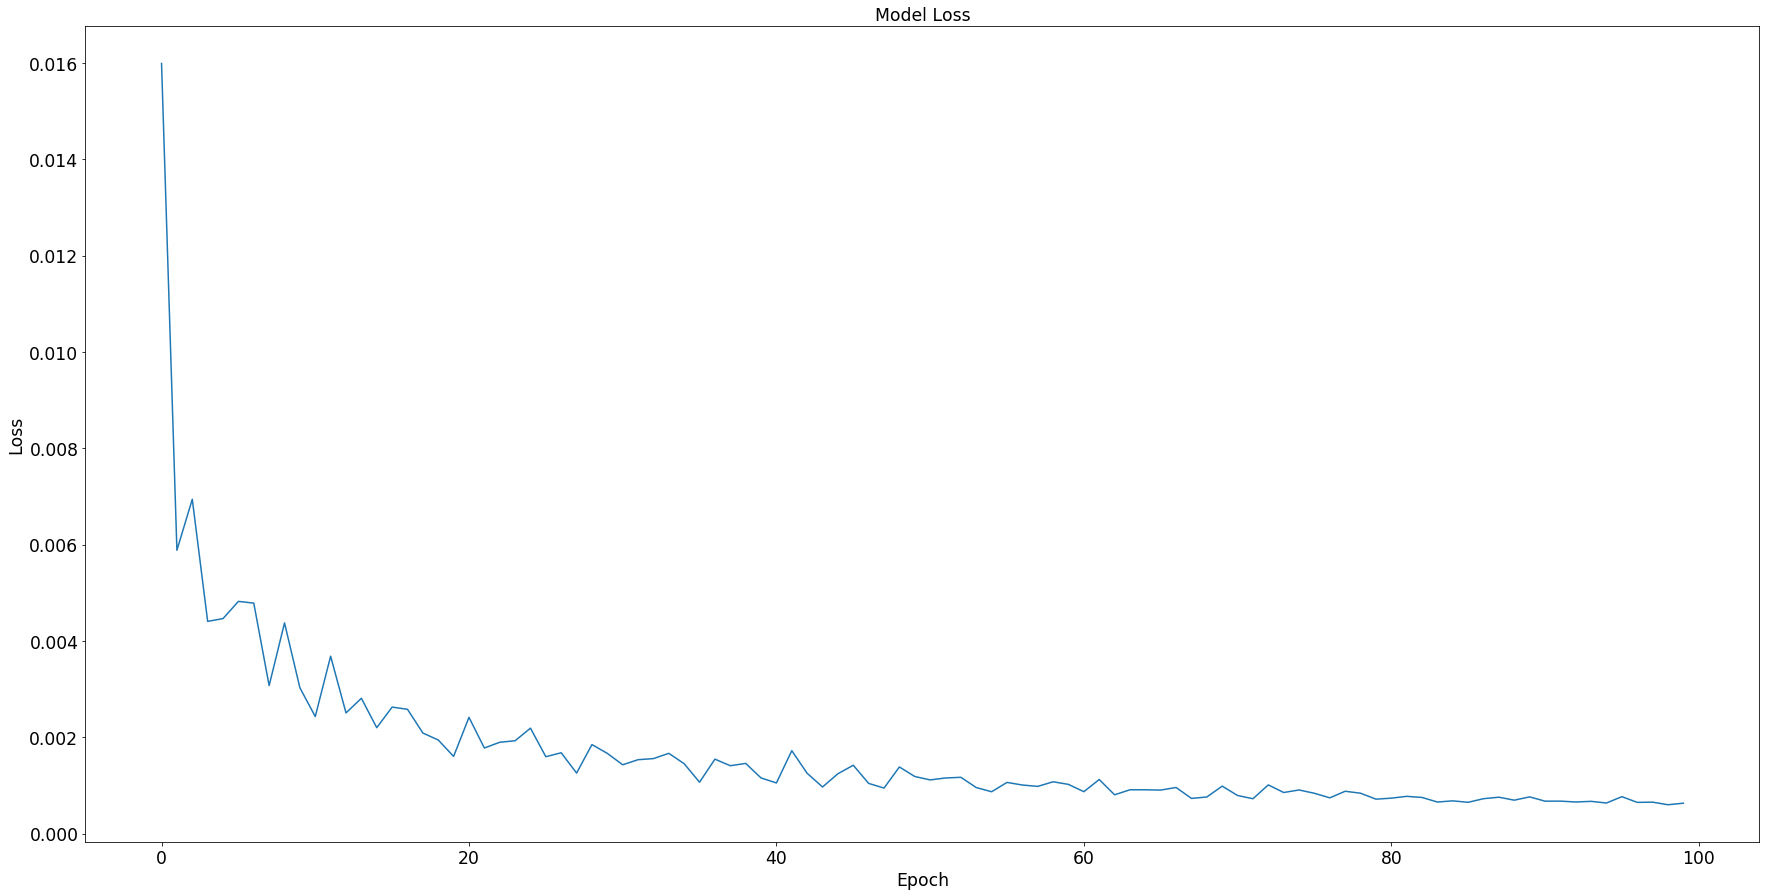

In [19]:
plot_loss(history_all_predictors)

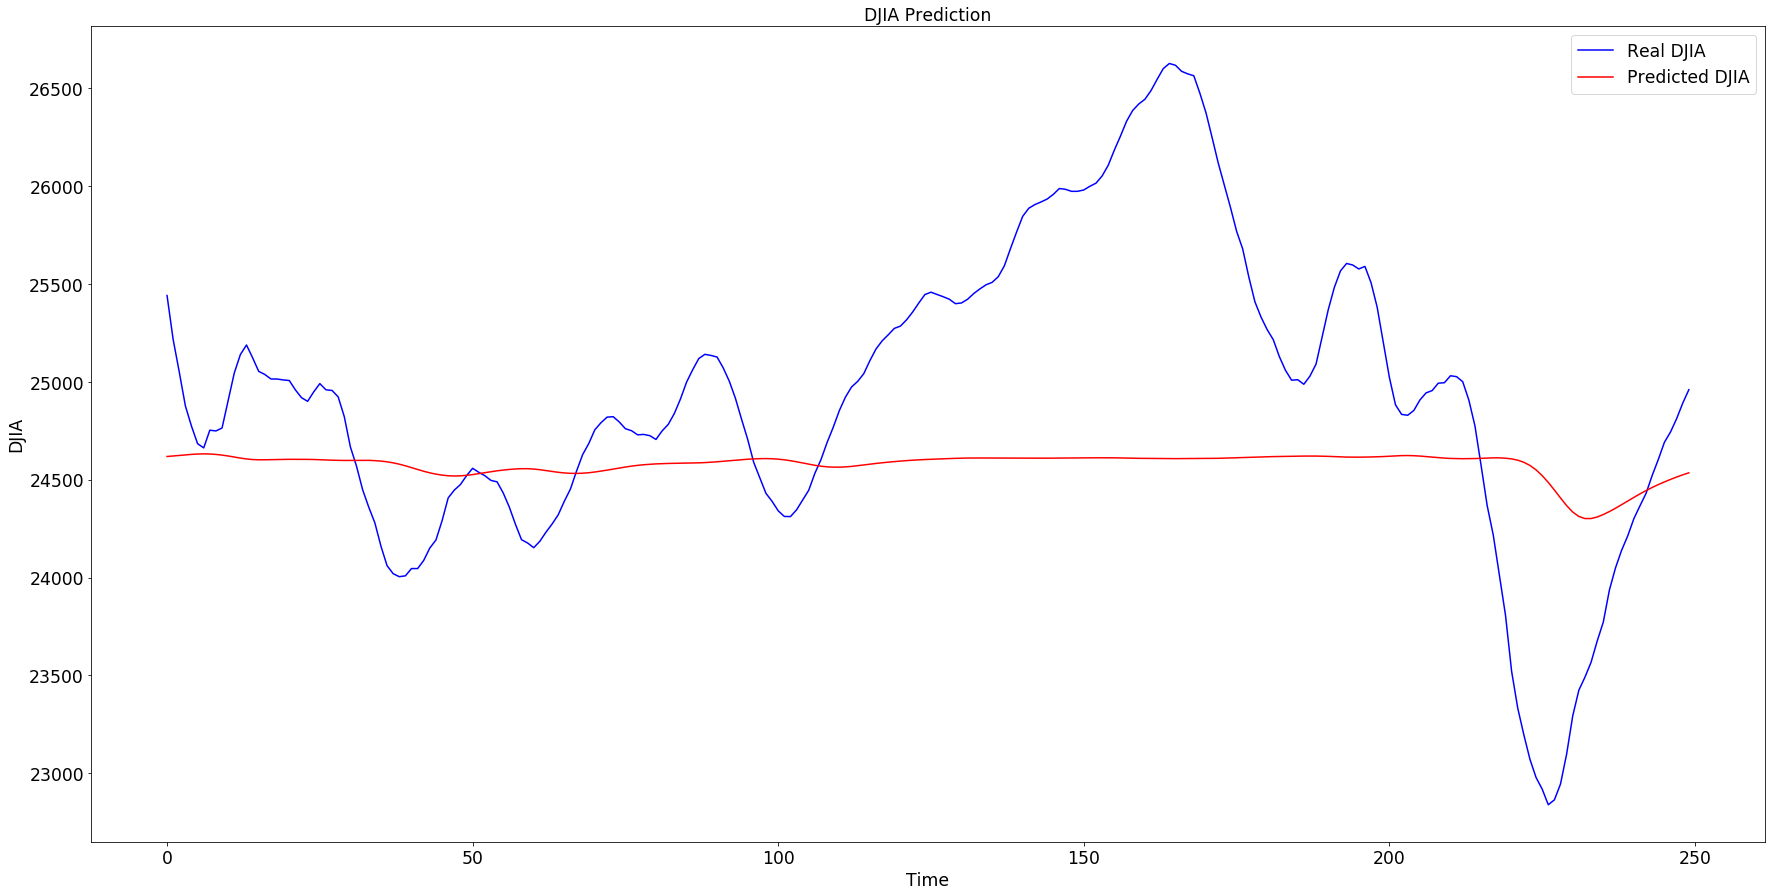

In [20]:
plot_prediction(scaler, x_test, y_test, model_all_predictors)

# Open Predictor Model

In [21]:
x_train, y_train, x_test, y_test = generate_train_test_prediction_windows(djia_matrix_train, djia_matrix_test, PREDICTION_WINDOW_SIZE, False)
model, history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS)

Epoch 1/100
650/650 [==============================] - 4s 7ms/step - loss: 0.0202
Epoch 2/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0087
Epoch 3/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0058
Epoch 4/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0049
Epoch 5/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0043
Epoch 6/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0041
Epoch 7/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0041
Epoch 8/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0030
Epoch 9/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0036
Epoch 10/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0021
Epoch 11/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0029
Epoch 12/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0030
Epoch 13/100


650/650 [==============================] - 2s 3ms/step - loss: 8.1986e-04
Epoch 98/100
650/650 [==============================] - 2s 3ms/step - loss: 7.9456e-04
Epoch 99/100
650/650 [==============================] - 2s 3ms/step - loss: 6.2626e-04
Epoch 100/100
650/650 [==============================] - 2s 3ms/step - loss: 7.1476e-04


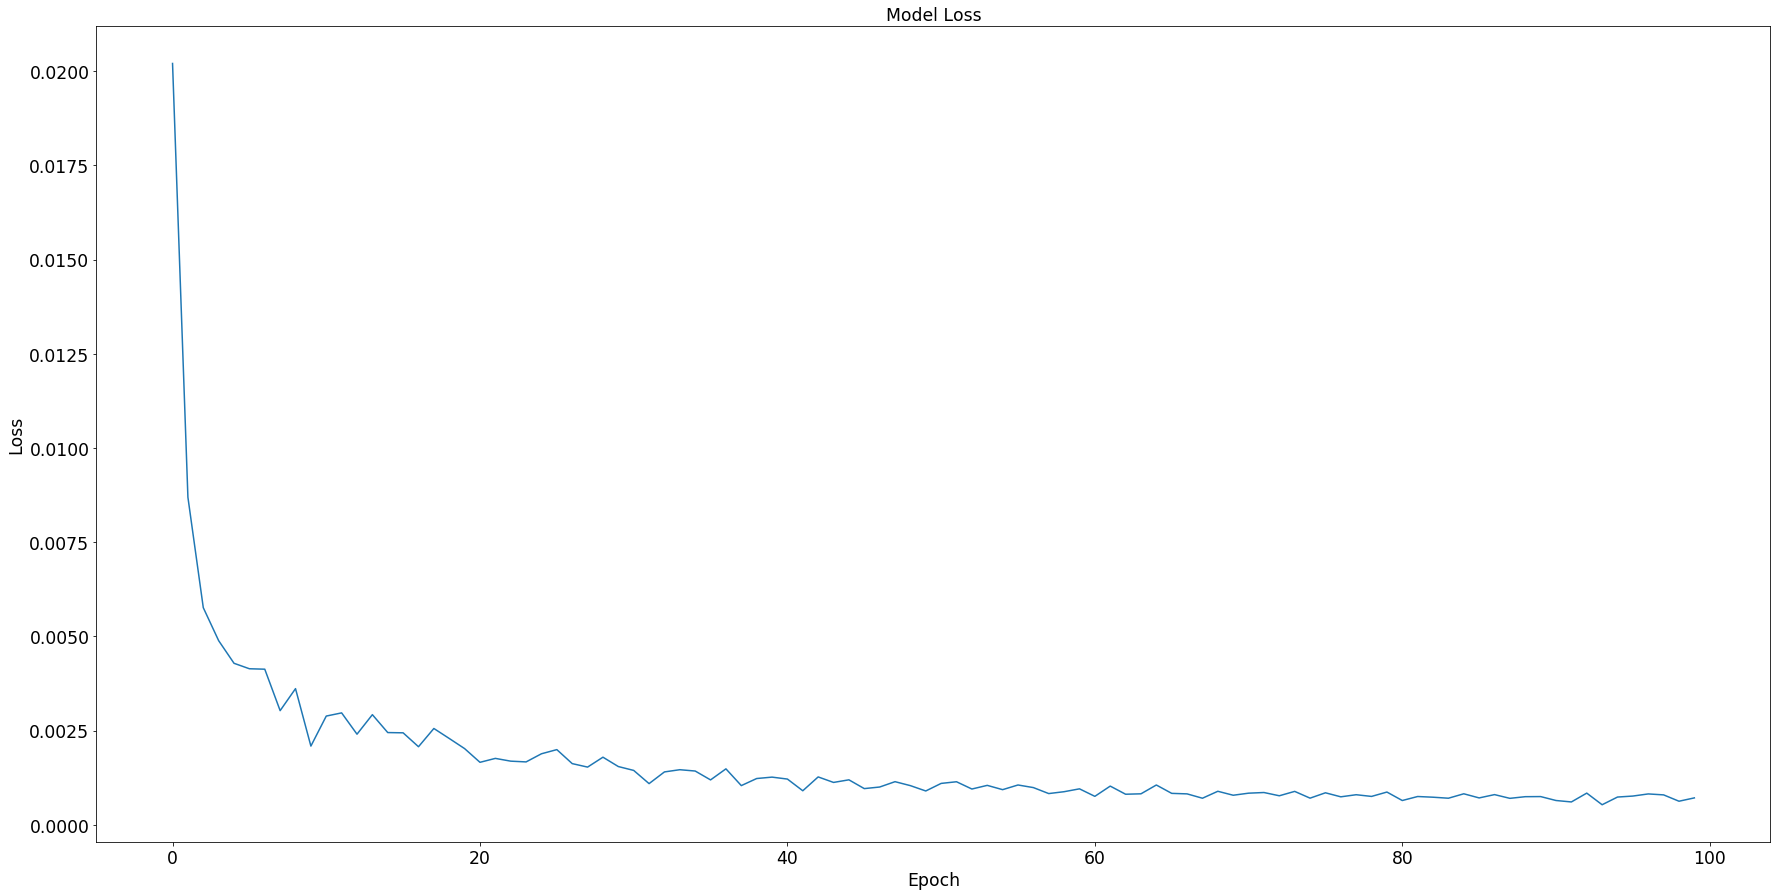

In [22]:
plot_loss(history)

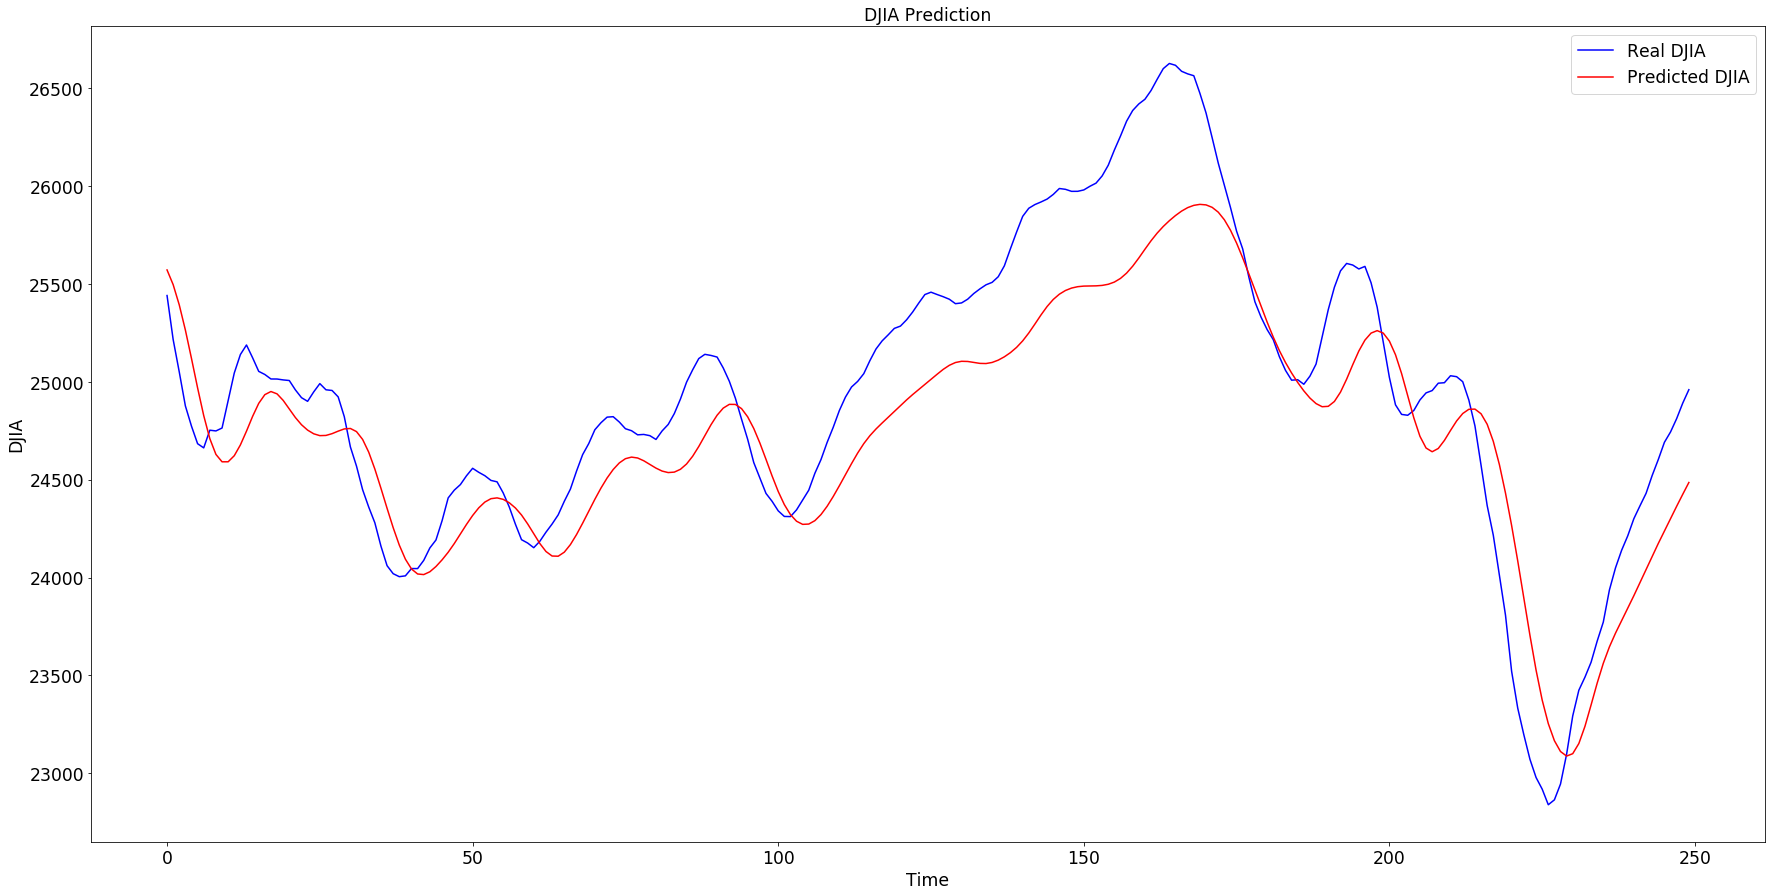

In [23]:
plot_prediction(scaler, x_test, y_test, model)